# Classification des Curriculum Vitae

Natural Language Processing

<hr>

- <a href='#1'>Prétraitement des données</a>
    - Import et prévisualisation des données
    - Encodage de la target
    - Traitement des Features
- <a href='#2'>WordClouds</a>
- <a href='#3'>Entrainement d'un modèle de Machine Learning</a>
    - Avec TFID Vectorizer et Random Forest Classifier
    - Avec Word2Vec et Sac de centroïdes

<hr>

In [1]:
import pandas as pd
import numpy as np
import gensim 
from gensim.models import Word2Vec 
import time as time
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from bs4 import BeautifulSoup
import unicodedata

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from keras.layers import Conv2D, experimental, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <a id='1'>Prétraitement des données</a>

#### Import et prévisualisation des données

In [2]:
df = pd.read_csv("DataSet.csv", sep=',')

In [3]:
df.head(3)

Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [5]:
print(f"Les CVs peuvent être classés dans {len(df.Category.unique())} catégories différentes :")
df.Category.value_counts()

Les CVs peuvent être classés dans 25 catégories différentes :


Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Mechanical Engineer          40
Blockchain                   40
Operations Manager           40
Sales                        40
ETL Developer                40
Data Science                 40
Arts                         36
Database                     33
Health and fitness           30
Electrical Engineering       30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

#### Encodage de la target

In [6]:
le = LabelEncoder()
Label = le.fit_transform(df.Category)

In [7]:
df["Label"]=Label
df

Category                                             Resume  Label
0    Data Science  Skills * Programming Languages: Python (pandas...      6
1    Data Science  Education Details \r\nMay 2013 to May 2017 B.E...      6
2    Data Science  Areas of Interest Deep Learning, Control Syste...      6
3    Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...      6
4    Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...      6
..            ...                                                ...    ...
957       Testing  Computer Skills: â¢ Proficient in MS office (...     23
958       Testing  â Willingness to accept the challenges. â ...     23
959       Testing  PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...     23
960       Testing  COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...     23
961       Testing  Skill Set OS Windows XP/7/8/8.1/10 Database MY...     23

[962 rows x 3 columns]

#### Traitement des Features

###### Préparation du texte

In [8]:
#premier prétraitement

def pretraitement(text):
    #lower case
    text = text.lower()
    #suppression des balises html éventuelles
    soup = BeautifulSoup(text, "html.parser") 
    text = soup.get_text()
    #suppression des caractère spéciaux ou accentués
    text = re.sub('\[[^]]*\]', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)

    words = text.split(" ")
    #suppression éventuels tokens vides
    words = list(filter(None, words))
    #suppression des stopwords
    words = [word for word in words if word not in stop_words] 
    
    # on retourne le résultat sous forme de string
    text = " ".join(words)
    return text 

###### Recherche des mots les plus courants, tous CVs confondus

In [9]:
# pour rechercher les mots les plus courants, on récupère la totalité des cvs prétraités dans une string (textG)
textG = str()
for i in df.index :
    textG += pretraitement(df["Resume"][i])

# on sépare cette string en liste de mots afin de pouvoir compter les occurences de chacun
wordsG = textG.split(' ') 

In [10]:
# utilisation du module counter de la bibliothèque Collections
from collections import Counter

counts = Counter(wordsG)

In [11]:
counts.most_common(25)

[('exprience', 3829),
 ('company', 3574),
 ('project', 3486),
 ('months', 3279),
 ('details', 3096),
 ('description', 3037),
 ('data', 2138),
 ('management', 1999),
 ('team', 1940),
 ('maharashtra', 1449),
 ('system', 1415),
 ('testing', 1349),
 ('year', 1328),
 ('database', 1276),
 ('development', 1203),
 ('business', 1180),
 ('test', 1174),
 ('ltd', 1161),
 ('less', 1145),
 ('using', 1124),
 ('sql', 1117),
 ('january', 1090),
 ('client', 1079),
 ('skill', 1075),
 ('java', 1070)]

On peut considérer que les mots qui reviennent plus de 1000 à 2000 fois dans l'ensemble des 962 CVs ne sont pas discriminants. Nous allons donc les retirer de la liste (second traitement)

In [12]:
commons = [counts.most_common()[i][0] for i in range(20)]
print("Suppression des mots les plus couramment rencontrés jusqu'à '{}'.".format(commons[-1:][0]))

Suppression des mots les plus couramment rencontrés jusqu'à 'using'.


In [13]:
def traitement2(text):
    words = text.split(" ")
    words = [word for word in words if word not in commons] #suppression des mots courants
    text = " ".join(words)
    return text

In [14]:
df['resume_processed']= np.zeros(len(df)).astype(int) # création d'une nouvelle colonne dans le dataframe

t = time.time()
for i in df.index: 
    df['resume_processed'][i] = traitement2(pretraitement(df["Resume"][i]))

print('Time to process the CVs dataset : {} secs'.format(round((time.time() - t), 2)))

C:\Users\utilisateur\anaconda3\envs\mypy36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\utilisateur\anaconda3\envs\mypy36\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Time to process the CVs dataset : 1.93 secs


## <a id='2'>WordClouds</a>

#### Nuage de mots sur la totalité des documents

In [15]:
textG = str()
for i in df.index :
    textG += df['resume_processed'].iloc[i]

In [16]:
wcloud = WordCloud(max_font_size=80, background_color='white').generate(textG)

Text(0.5, 1.0, 'Nuage de mots sur la totalité des contenus des CVs reçus')

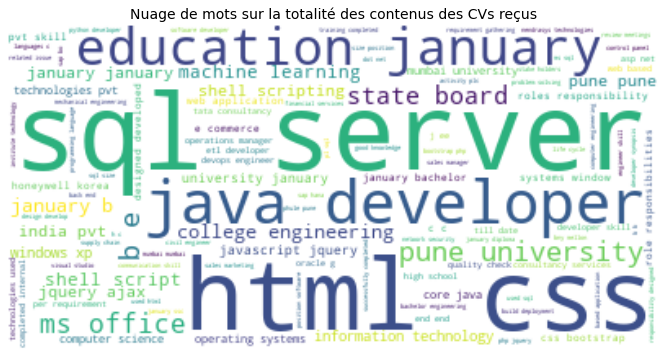

In [17]:
plt.figure(figsize=(12,6))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis("off")
plt.title(label="Nuage de mots sur la totalité des contenus des CVs reçus", fontsize=14)

###### Création des nuages de mots selon la catégorie d'emploi

In [18]:
categories = df.Category.unique()

In [19]:
def draw_wordcloud(categories) :
    
    clouds = []
    for cat in categories : 
        dfA = df.loc[df['Category']==cat]
        textA = str()
        for i in dfA.index :
            textA += str([df['resume_processed'].iloc[i] for i in dfA.index])
        wcloudA = WordCloud(max_font_size=60,  background_color='white').generate(textA)
        clouds.append(wcloudA)
        
    # visualisation
    plt.figure(figsize=(20,6*len(categories)//2))
    for i, cl in enumerate(clouds):
        plt.subplot(len(categories)//2+1,2,i+1)
        plt.imshow(cl, cmap='rainbow')
        plt.axis("off")
        plt.title(label=f"Wordcloud '{categories[i]}'", fontsize=16)


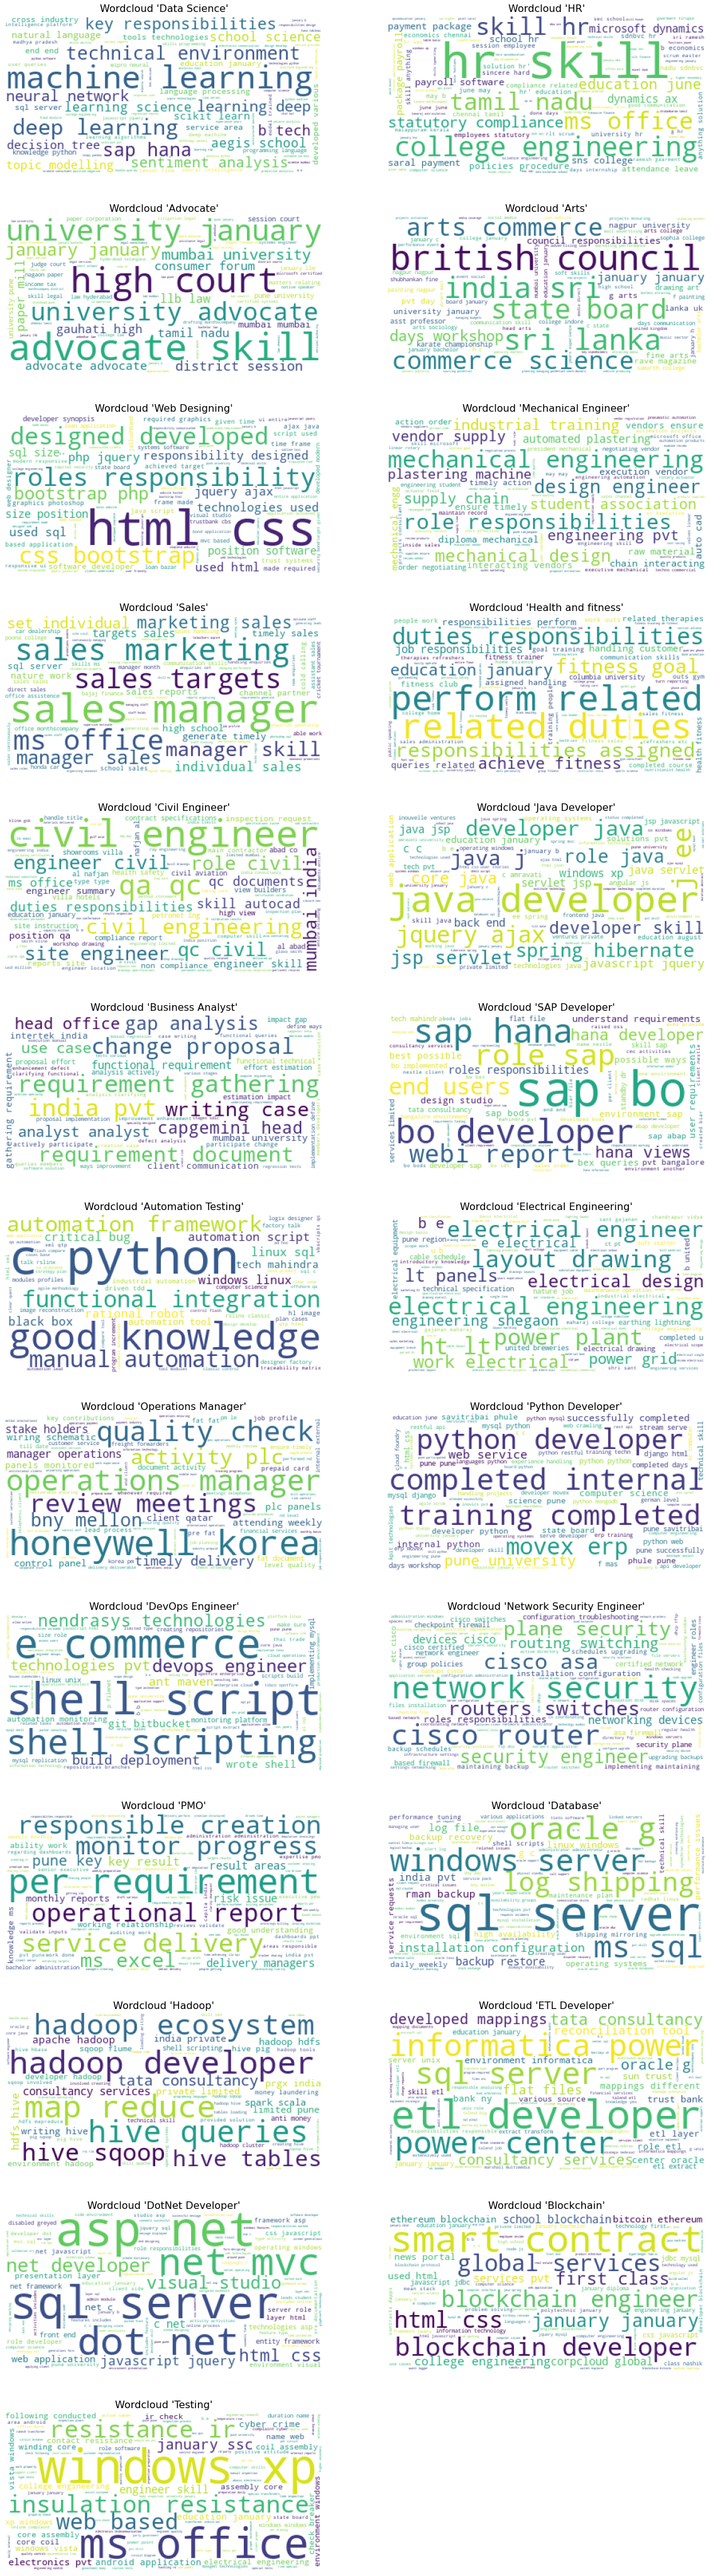

In [20]:
draw_wordcloud(categories)

L'observation rapide de ces nuages de mots nous montre qu'ils sont bien différents selon les métiers visés. La discrimination selon le type de candidature devrait dont être assez aisée.

## <a id='3'>Entrainement d'un modèle de Machine Learning</a>

### Avec TFID Vectorizer et Random Forest Classifier

In [21]:
X = df['resume_processed'].values
y = df['Label'].values

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [23]:
vectorizerTFID = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
XVec_trainTFID = vectorizerTFID.fit_transform(X_train)

In [24]:
XVec_val = vectorizerTFID.transform(X_val)

In [25]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(XVec_trainTFID, y_train)

y_pred = clf.predict(XVec_val)

In [26]:
score = accuracy_score(y_val,y_pred)
print('On obtient une accuracy de {}% sur la base de test de {} entrées.'.format(round(score*100,1), len(y_val)))

On obtient une accuracy de 100.0% sur la base de test de 193 entrées.


<AxesSubplot:title={'center':'Matrice de confusion avec la méthode TFID Vectorizer'}>

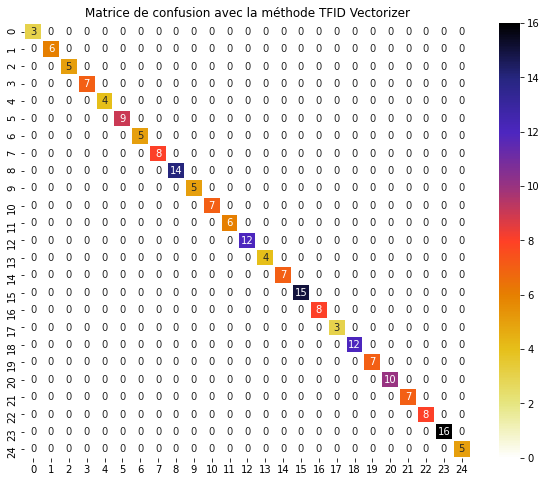

In [27]:
import seaborn as sns

plt.figure(figsize=(10,8))
plt.title("Matrice de confusion avec la méthode TFID Vectorizer")
cf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='CMRmap_r', linewidth=1)

Notre modèle n'a fait qu'une seule erreur sur la base de test qui comporte 193 documents. Ce modèle est donc efficace est peut servir à rediriger les candidatures reçues vers le service concerné de façon efficace.

### Avec Word2Vec et Sac de centroïdes

In [28]:
from sklearn.cluster import KMeans
from gensim.models import Word2Vec

In [29]:
documents =[]

for i in df.index:
    documents.append(df['resume_processed'][i].split(' '))
print("nombre total de CVs :", len(documents))
print("nombre de mots dans les 10 premiers :",[len(documents[i]) for i in range(10)])

nombre total de CVs : 962
nombre de mots dans les 10 premiers : [476, 95, 146, 625, 16, 54, 132, 746, 179, 361]


In [30]:
import multiprocessing
cores = multiprocessing.cpu_count()

# paramètres : documentation = https://radimrehurek.com/gensim/models/word2vec.html
num_features = 300    # Taille des vecteurs-mots                     
min_word_count = 30   # Minimum d'apparition du mot (fréquence) pour pouvoir entrer dans le vocabulaire                       
num_workers = cores-1 # Nombre de threads qui peuvent tourner en parallèle                                                                               
downsampling = 1e-3   # "Downsample setting for frequent words" > ?
win_context = 10      # Distance max entre le mot-cible et les mots autour
#alpha=0.03           
#min_alpha=0.0007
#negative=20

In [31]:
model = Word2Vec(min_count=min_word_count,
                     size=num_features,
                     window=win_context,
                     sample=downsampling, 
                     workers=num_workers)

t = time.time()
model.build_vocab(documents, progress_per=10000)
print('Time to build vocab: {} sec'.format(round((time.time() - t), 2)))
print("Nombre total de CVs :", model.corpus_count)
print("Nombre de mots dans le vocabulaire :", len(model.wv.index2word))
print("Taille des vecteurs-mots :", model.vector_size)
print("Dimension de la matrice des vecteurs-mots :", model.wv.vectors.shape)

model.init_sims(replace=True) # optional, init_sims makes the model more memory-efficient.

Time to build vocab: 0.53 sec
Nombre total de CVs : 962
Nombre de mots dans le vocabulaire : 1741
Taille des vecteurs-mots : 300
Dimension de la matrice des vecteurs-mots : (1741, 300)


In [32]:
model.wv.most_similar("advocate")

[('defect', 0.17684422433376312),
 ('bed', 0.17566007375717163),
 ('inc', 0.17466944456100464),
 ('location', 0.17116570472717285),
 ('angular', 0.1578141301870346),
 ('station', 0.15363045036792755),
 ('simultaneously', 0.1513398438692093),
 ('deploy', 0.14979329705238342),
 ('cad', 0.149416983127594),
 ('road', 0.14811311662197113)]

In [33]:
model.wv.most_similar("java")

[('maintained', 0.18055471777915955),
 ('learn', 0.1704835146665573),
 ('vlan', 0.16536638140678406),
 ('reviewed', 0.1646222323179245),
 ('admin', 0.16404524445533752),
 ('regression', 0.16361288726329803),
 ('b', 0.16232872009277344),
 ('models', 0.15951626002788544),
 ('late', 0.15740233659744263),
 ('liasing', 0.15612046420574188)]

In [34]:
model.wv.most_similar("blockchain")

[('initiative', 0.17277991771697998),
 ('experience', 0.17152485251426697),
 ('academic', 0.16756117343902588),
 ('formalities', 0.1608247309923172),
 ('compliance', 0.15851327776908875),
 ('flume', 0.1547485888004303),
 ('task', 0.15300485491752625),
 ('annual', 0.15179768204689026),
 ('back', 0.15088561177253723),
 ('sessions', 0.15072807669639587)]

In [35]:
def mean_vector(sentence, model):
    total = np.zeros((model.vector_size,))
    count = 0
    for word in sentence : 
        try:
            add = model.wv[word]
            count += 1
            total += add
        except KeyError:
            continue
    mean = total/count
    return mean

In [36]:
def build_matrix(sentences_list, model):
    t = time.time()
    vectors_list = []
    for sentence in sentences_list : 
        vectors_list.append(mean_vector(sentence, model))
        
    vect_mat = []
    for v in vectors_list :
        vect_mat.append(v)
    vect_mat = np.asarray(vect_mat).reshape(len(vectors_list),model.vector_size)
    print('Time to build the matrix : {} secs'.format(round((time.time() - t), 2)))
    print("Matrix of shape", vect_mat.shape, "built succesfully")
    return vect_mat

In [37]:
XVec_trainW2V = build_matrix(X_train, model)

Time to build the matrix : 5.3 secs
Matrix of shape (769, 300) built succesfully


In [38]:
XVec_valW2V = build_matrix(X_val, model)

Time to build the matrix : 1.4 secs
Matrix of shape (193, 300) built succesfully


In [39]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(XVec_trainTFID, y_train)

y_pred = clf.predict(XVec_val)

In [40]:
score = accuracy_score(y_val,y_pred)
print('On obtient une accuracy de {}% sur la base de test de {} entrées.'.format(round(score*100,1), len(y_val)))

On obtient une accuracy de 100.0% sur la base de test de 193 entrées.


<AxesSubplot:title={'center':'Matrice de confusion avec la méthode Sac de Centroïdes'}>

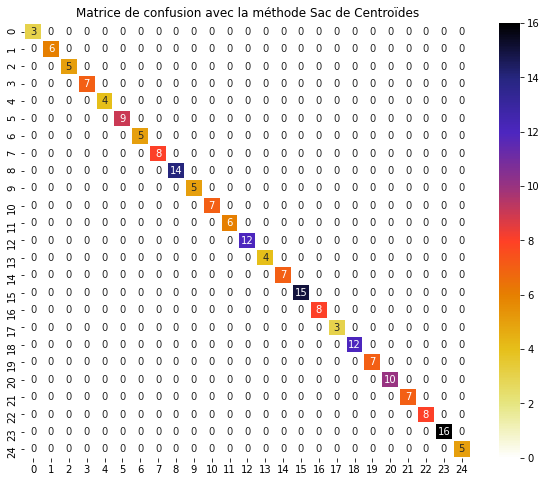

In [41]:
import seaborn as sns

plt.figure(figsize=(10,8))
plt.title("Matrice de confusion avec la méthode Sac de Centroïdes")
cf_matrix = confusion_matrix(y_val, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='CMRmap_r', linewidth=1)